In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from catboost import Pool, CatBoostClassifier
import numpy as np
import re
from string import punctuation
from sklearn.metrics import roc_curve, auc

            +------------+     +---------------+     +-----------+
            | user_data  |     | post_text_df  |     | feed_data |
            +------------+     +---------------+     +-----------+
            | age        |     | id            |     | timestamp |
            | city       |     | text          |     | user_id   |
            | country    |     | topic         |     | post_id   |
            | exp_group  |     +---------------+     | action    |
            | gender     |           7,023           | target    |
            | id         |                           +-----------+
            | os         |                             76,892,800
            | source     |
            +------------+
                163,205 

In [2]:
engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@" # this is the username and password
        "postgres.lab.karpov.courses:6432/startml" # this is the connection string to the database
    )

'''User_data'''

# Чтение данных таблицы user_data
query = "SELECT * FROM user_data"
user_data = pd.read_sql(query, engine)

# remove city, country, os, source, exp_group columns from user_data
user_data = user_data.drop(columns=['city', 'country', 'os', 'source', 'exp_group', 'gender'])

'''post_text_df'''

# Чтение данных таблицы post_text_df
query = "SELECT * FROM post_text_df"
post_text_df = pd.read_sql(query, engine)

# Add a new column to the user_data table representing the length of text
post_text_df['text_length'] = post_text_df['text'].apply(lambda x: len(x.split()))

# remove text column from post_text_df
post_text_df = post_text_df.drop(columns=['text'])

# label encoding for topic column
le = LabelEncoder()
post_text_df['topic_1'] = le.fit_transform(post_text_df['topic'])


'''Общее'''

# Переименование столбцов идентификаторов
user_data = user_data.rename(columns={'id': 'user_id'})
post_text_df = post_text_df.rename(columns={'id': 'post_id'})

'''feed_data'''

# Чтение feed_data из csv файла
feed_data = pd.read_csv(r'C:\Users\Alex\Desktop\feed_data.csv')
print(f"Feed data shape: {feed_data.shape}")

'''Merging'''
# Объединение таблиц
data = feed_data.merge(user_data, on='user_id', how='left')
data = data.merge(post_text_df, on='post_id', how='left')


Feed data shape: (76892800, 5)


In [3]:
data

,timestamp,user_id,post_id,action,target,age,topic,text_length,topic_1
0,2021-12-26 16:40:07,52431,6920,view,0,34,movie,193,3
1,2021-12-26 16:42:42,52431,3840,view,0,34,covid,23,1
2,2021-12-26 16:45:27,52431,1716,view,0,34,sport,406,5
3,2021-12-26 16:46:39,52431,1054,view,0,34,politics,313,4
4,2021-12-26 16:48:54,52431,963,view,0,34,politics,445,4
...,...,...,...,...,...,...,...,...,...
76892795,2021-12-26 16:31:03,52431,2398,view,0,34,covid,11,1
76892796,2021-12-26 16:33:12,52431,4233,view,0,34,movie,58,3
76892797,2021-12-26 16:33:34,52431,6585,view,0,34,movie,192,3
76892798,2021-12-26 16:36:30,52431,750,view,0,34,entertainment,399,2


In [4]:
import pandas as pd

# Assuming your DataFrame is named as 'data'

# Let's create a subset dataframe with only 'view' actions
views_df = data[data['action'] == 'view']

# Now, let's count views per post
views_per_post = views_df['post_id'].value_counts()

# Let's create a subset dataframe with only 'like' actions
likes_df = data[data['action'] == 'like']

# Now, let's count likes per post
likes_per_post = likes_df['post_id'].value_counts()

# Now, let's merge these two series into a new dataframe
post_stats = pd.DataFrame({
    'views': views_per_post,
    'likes': likes_per_post
})

# Replace NaN values with 0 (assuming that NaN means there were no likes/views)
post_stats.fillna(0, inplace=True)

# Let's calculate the likes percentage for each post from all likes
total_likes = post_stats['likes'].sum() # Total likes across all posts
post_stats['like_percentage'] = (post_stats['likes'] / total_likes) * 100

# Let's reset the index so 'post_id' becomes a column
post_stats.reset_index(inplace=True)
post_stats.rename(columns={'index': 'post_id'}, inplace=True)

# Now we merge this dataframe with the original one, on 'post_id'
# 'left' ensures that all rows in the original data are kept, even if they don't have a match in post_stats
data = pd.merge(data, post_stats, on='post_id', how='left')


In [5]:
data

,timestamp,user_id,post_id,action,target,age,topic,text_length,topic_1,views,likes,like_percentage
0,2021-12-26 16:40:07,52431,6920,view,0,34,movie,193,3,6610,717,0.008737
1,2021-12-26 16:42:42,52431,3840,view,0,34,covid,23,1,22496,2842,0.034632
2,2021-12-26 16:45:27,52431,1716,view,0,34,sport,406,5,22072,2807,0.034205
3,2021-12-26 16:46:39,52431,1054,view,0,34,politics,313,4,12219,871,0.010614
4,2021-12-26 16:48:54,52431,963,view,0,34,politics,445,4,22136,2804,0.034169
...,...,...,...,...,...,...,...,...,...,...,...,...
76892795,2021-12-26 16:31:03,52431,2398,view,0,34,covid,11,1,6813,732,0.008920
76892796,2021-12-26 16:33:12,52431,4233,view,0,34,movie,58,3,16957,2527,0.030793
76892797,2021-12-26 16:33:34,52431,6585,view,0,34,movie,192,3,6659,677,0.008250
76892798,2021-12-26 16:36:30,52431,750,view,0,34,entertainment,399,2,8702,1080,0.013161


In [6]:
# Group by 'topic' and calculate mean likes per topic
topic_means_likes = data.groupby('topic_1')['likes'].mean()

# Convert this Series to a DataFrame and reset the index
topic_means_likes = topic_means_likes.reset_index()

# Rename the columns to something more understandable
topic_means_likes.columns = ['topic_1', 'average_likes']

# Now we merge this dataframe with the original one, on 'topic'
data = pd.merge(data, topic_means_likes, on='topic_1', how='left')

# One-hot encoding for topic column
data = pd.get_dummies(data, columns=['topic'])

# drop topic_1 column from data
data = data.drop(columns=['topic_1'])

In [7]:
topic_means_likes

,topic_1,average_likes
0,0,1216.625181
1,1,1481.118654
2,2,1200.533425
3,3,1376.696927
4,4,2196.697049
5,5,2549.522470
6,6,1014.975894


In [8]:
data 

,timestamp,user_id,post_id,action,target,age,text_length,views,likes,like_percentage,average_likes,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
0,2021-12-26 16:40:07,52431,6920,view,0,34,193,6610,717,0.008737,1376.696927,False,False,False,True,False,False,False
1,2021-12-26 16:42:42,52431,3840,view,0,34,23,22496,2842,0.034632,1481.118654,False,True,False,False,False,False,False
2,2021-12-26 16:45:27,52431,1716,view,0,34,406,22072,2807,0.034205,2549.522470,False,False,False,False,False,True,False
3,2021-12-26 16:46:39,52431,1054,view,0,34,313,12219,871,0.010614,2196.697049,False,False,False,False,True,False,False
4,2021-12-26 16:48:54,52431,963,view,0,34,445,22136,2804,0.034169,2196.697049,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76892795,2021-12-26 16:31:03,52431,2398,view,0,34,11,6813,732,0.008920,1481.118654,False,True,False,False,False,False,False
76892796,2021-12-26 16:33:12,52431,4233,view,0,34,58,16957,2527,0.030793,1376.696927,False,False,False,True,False,False,False
76892797,2021-12-26 16:33:34,52431,6585,view,0,34,192,6659,677,0.008250,1376.696927,False,False,False,True,False,False,False
76892798,2021-12-26 16:36:30,52431,750,view,0,34,399,8702,1080,0.013161,1200.533425,False,False,True,False,False,False,False


Time features encoding

In [9]:
# get all the info on timestamp column from data
data['timestamp'].describe()

count                76892800
unique                2598589
top       2021-10-16 16:51:22
freq                      192
Name: timestamp, dtype: object

In [10]:
'''
data['timestamp'] = pd.to_datetime(data['timestamp'])

data['year'] = data['timestamp'].dt.year
data['month'] = data['timestamp'].dt.month
data['day'] = data['timestamp'].dt.day
data['hour'] = data['timestamp'].dt.hour
data['minute'] = data['timestamp'].dt.minute

# if hour is between 6 and 12, then it's morning
data['morning'] = data['hour'].apply(lambda x: 1 if 6 <= x < 12 else 0)

# if hour is between 12 and 18, then it's afternoon
data['afternoon'] = data['hour'].apply(lambda x: 1 if 12 <= x < 18 else 0)

# if hour is between 18 and 24, then it's evening
data['evening'] = data['hour'].apply(lambda x: 1 if 18 <= x < 24 else 0)

data = data.drop('timestamp', axis=1)
'''

data['timestamp'] = pd.to_datetime(data['timestamp'])
#data['month'] = data['timestamp'].dt.month

# Convert datetime to Unix timestamp (seconds since 1970-01-01 00:00:00 UTC)
data['timestamp'] = (data['timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [11]:
data

,timestamp,user_id,post_id,action,target,age,text_length,views,likes,like_percentage,average_likes,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
0,1640536807,52431,6920,view,0,34,193,6610,717,0.008737,1376.696927,False,False,False,True,False,False,False
1,1640536962,52431,3840,view,0,34,23,22496,2842,0.034632,1481.118654,False,True,False,False,False,False,False
2,1640537127,52431,1716,view,0,34,406,22072,2807,0.034205,2549.522470,False,False,False,False,False,True,False
3,1640537199,52431,1054,view,0,34,313,12219,871,0.010614,2196.697049,False,False,False,False,True,False,False
4,1640537334,52431,963,view,0,34,445,22136,2804,0.034169,2196.697049,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76892795,1640536263,52431,2398,view,0,34,11,6813,732,0.008920,1481.118654,False,True,False,False,False,False,False
76892796,1640536392,52431,4233,view,0,34,58,16957,2527,0.030793,1376.696927,False,False,False,True,False,False,False
76892797,1640536414,52431,6585,view,0,34,192,6659,677,0.008250,1376.696927,False,False,False,True,False,False,False
76892798,1640536590,52431,750,view,0,34,399,8702,1080,0.013161,1200.533425,False,False,True,False,False,False,False


In [ ]:
# drop 'action' column
data = data.drop(columns=['action'])

In [ ]:
'''Обрезка данных'''
def sample_10_percent(group):
    frac = 0.1
    return group.sample(frac=frac)

data_sample_10 = data.groupby('post_id', group_keys=False).apply(sample_10_percent)

# save data_sample_10 to csv file on desktop
data_sample_10.to_csv(r'C:\Users\Alex\Desktop\data_sample_10.csv', index=False)

In [18]:
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame and 'target' is the column you want to predict
X = data.drop('target', axis=1)  # input features (make sure to drop the target column)
y = data['target']  # target variable

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
# check format of timestamp column
print(X_train['timestamp'].head())

47738720    1640259933
71062193    1635268174
16465677    1634899671
901259      1633803797
4211501     1634677865
Name: timestamp, dtype: int64


In [36]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame and 'target' is the column you want to predict
X = data.drop(['target', 'post_id', 'user_id'], axis=1)  # input features (make sure to drop the target column)
y = data['target']  # target variable

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a list of categorical features
cat_features = ['topic']  # Modify this list based on your actual categorical features

# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,  # Modify this parameter as needed
    thread_count=-1,  
    eval_metric='PRAUC',  # Changed to PR AUC
    verbose=200,  # Output the training process every 200 iterations
    random_seed=42
)

# Fit model
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test))


Learning rate set to 0.273392
0:	learn: 0.2522423	test: 0.2522178	best: 0.2522178 (0)	total: 1.01s	remaining: 16m 48s


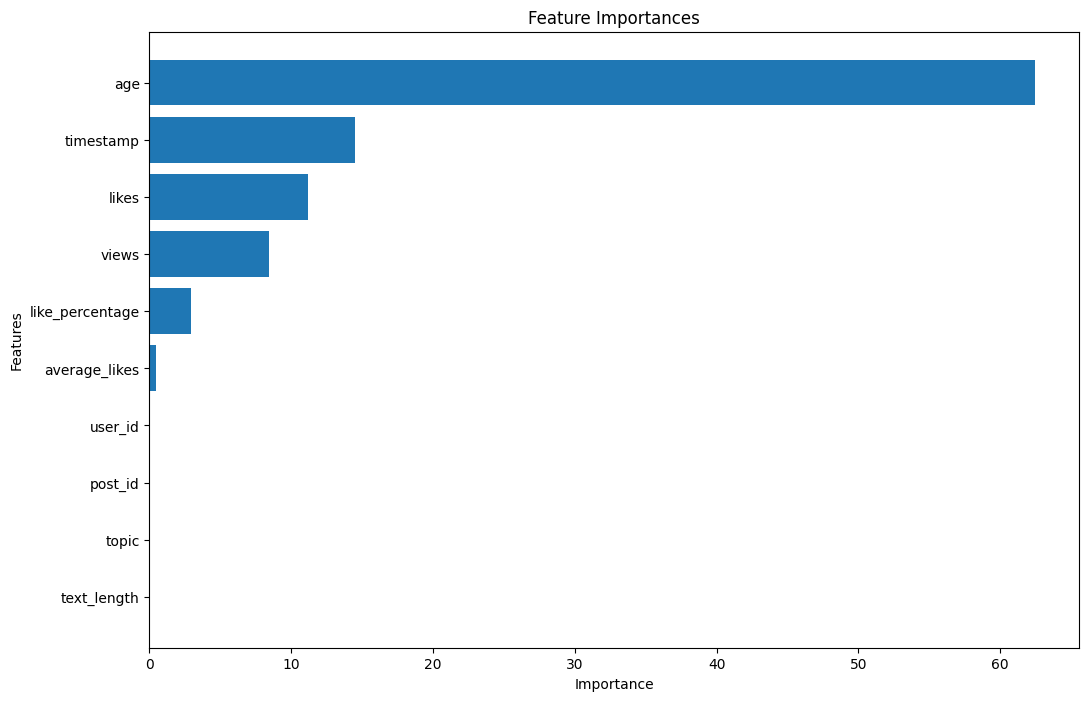

In [32]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = model.get_feature_importance()

# Create a pandas dataframe for easier visualization
importance_df = pd.DataFrame({
    'Features': X.columns,
    'Importance': feature_importances
})

# Sort the dataframe based on the feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Features'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
def hitrate5(model, X, Y):
    check = pd.concat([Y,
                       pd.Series(model.predict_proba(X)[:,1], index=Y.index, name='probas')],
                      axis=1)
    check = check.reset_index().drop(columns='post_id')
    
    pred_list = [check[check.user_id == user_id].sort_values('probas', ascending=False).iloc[:5]
                 for user_id in check.user_id.unique()]

    return pd.concat(pred_list).groupby('user_id').target.sum().map(lambda x: min(1, x)).mean()

hitrate5(model, X_test, y_test)

In [29]:
# Get the prediction probabilities
y_pred_proba = model.predict_proba(validation_data)[:, 1]

# Add the prediction probabilities to the test dataset
X_test['pred_proba'] = y_pred_proba

# Let's say you have a list of 2000 user_ids for which you want to make predictions
user_ids_2000 = X_test['user_id'].unique()[:2000]  # Modify this as per your need

# Filter the test dataset for these 2000 user_ids
X_test_2000 = X_test[X_test['user_id'].isin(user_ids_2000)]
y_test_2000 = y_test[X_test['user_id'].isin(user_ids_2000)]

# Group by 'user_id' and find the top 5 predicted 'post_id' for each user
top_5_posts_2000 = X_test_2000.groupby('user_id').apply(lambda x: x.nlargest(5, 'pred_proba')['post_id'])


def hitrate_at_k(X_test, y_test, top_k_posts, k=5):
    hits = 0
    total_checks = 0

    # Получаем уникальные идентификаторы пользователей из тестового набора данных
    user_ids = X_test['user_id'].unique()

    for user_id in user_ids:
        # Получаем список из топ-5 предсказанных идентификаторов записей для данного пользователя
        top_k_pred = list(top_k_posts.loc[user_id])

        # Получаем фактические идентификаторы записей, которые пользователь оценил положительно
        true_post_ids = list(X_test[(X_test['user_id'] == user_id) & (y_test == 1)]['post_id'])

        # Увеличиваем счетчик общего числа проверок
        total_checks += 1

        # Если хотя бы одна из пяти рекомендованных записей присутствует в положительно оцененных пользователем записях
        if set(top_k_pred) & set(true_post_ids):
            hits += 1

    # Рассчитываем показатель попадания (hit rate) как отношение числа проверок, в которых хотя бы одна из пяти рекомендованных записей оказалась положительно оцененной
    hitrate_at_k = hits / total_checks if total_checks > 0 else 0

    return hitrate_at_k


# Now we can compute the hitrate for these 2000 users
hitrate_at_5_2000 = hitrate_at_k(X_test_2000, y_test_2000, top_5_posts_2000, k=5)

print("Hit Rate at k=5 for 2000 users: ", hitrate_at_5_2000)


Hit Rate at k=5 for 2000 users:  0.533
